## Pupila movement analysis
### Bernardo AO

In [ ]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

data_path = r"D:\NP data\Bernardo_awake_cx\DLC\example"
os.chdir(data_path)
#files = [f for f in os.listdir() if f[-6:] == "pickel"]

with open('cam1_2021-11-19-14-41-58DLC_Resnet50_Retina movementOct1shuffle1_snapshot_010_full.pickle', 'rb') as f:
    data = pickle.load(f)

C:\Users\1\AppData\Local\Temp\ipykernel_13784\3361438235.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


In [ ]:
n_pupil = 8
n_eyelid = 4
n_frames = data["metadata"]['nframes']
fps = 200 # Hz
tv = np.arange(0, n_frames / fps, 1 / fps)
ROIs = np.zeros((n_pupil + n_eyelid, 2, n_frames))
keys = list(data.keys())

for frame in range(n_frames):
    frame_name = keys[frame + 1]
    ROI = np.array(data[frame_name]['coordinates']).reshape(n_pupil + n_eyelid, 2)
    ROIs[:,:,frame] = ROI


In [41]:
def smooth_ROI(ROIs, win):
    ROIs_smooth = np.copy(ROIs)

    for t in range(win, ROIs.shape[2] - win):
        ROIs_smooth[:,:,t] = np.median(ROIs[:,:,t-win:t+win],2)
    return ROIs_smooth

smooth_window = 3
ROIs_smooth = smooth_ROI(ROIs, smooth_window)

(115.79826304912567, 148.0209865808487)

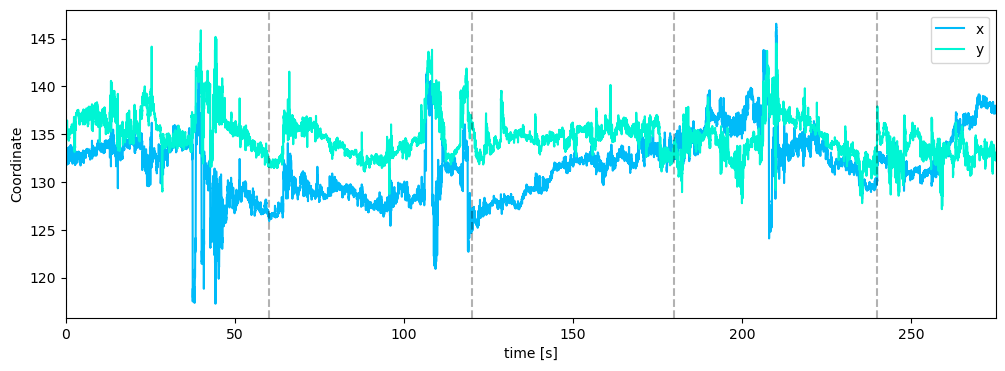

In [ ]:
retina_center = np.mean(ROIs_smooth[:n_pupil,:,:], 0)
eyelid_center = np.mean(ROIs[n_pupil:,:,:], 0)
#retina_center -= eyelid_center

plt.figure(figsize=(12,4))
plt.plot(tv, retina_center[0,:], color="#00bbf9")
plt.plot(tv, retina_center[1,:], color="#00f5d4")
plt.xlim([tv[0],tv[-1]])
plt.xlabel("time [s]")
plt.ylabel("Coordinate")
plt.legend(["x","y"])

axes = plt.gca()
ylim = axes.get_ylim()
minutes = np.arange(0,tv[-1],60)
plt.vlines(minutes, ylim[0], ylim[1], colors="k",linestyles="--",alpha=0.3)
plt.ylim(ylim)
plt.show()

In [61]:
opp = n_pupil // 2
pupil_sizes = np.zeros((opp, len(tv)))
for pair in range(opp):
    diff = ROIs_smooth[pair,:,:] - ROIs_smooth[pair + opp,:,:]
    pupil_sizes[pair,:] = np.sqrt(diff[0,:]**2 + diff[1,:]**2)
pupil_size = np.mean(pupil_sizes, 0)

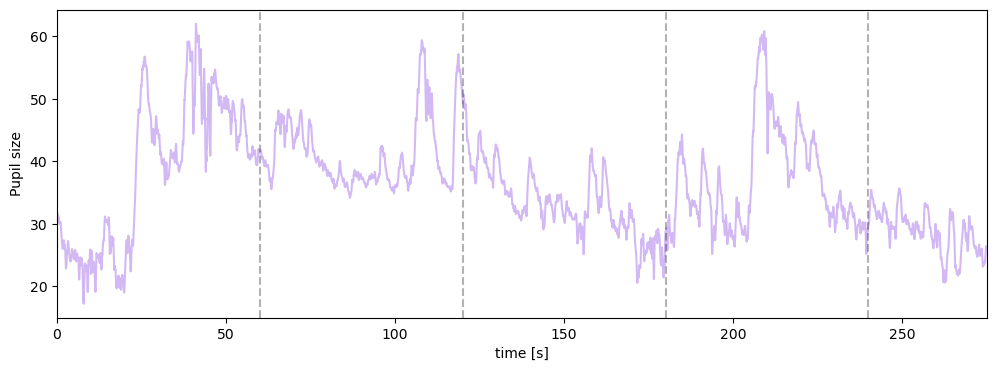

In [ ]:
pupil_size_clean = signal.savgol_filter(pupil_size, window_length=100, polyorder=2)

plt.figure(figsize=(12,4))
#plt.plot(tv, pupil_size, color="#9b5de5")
plt.plot(tv, pupil_size_clean, color="#D3B9F4")

plt.xlim([tv[0],tv[-1]])
plt.xlabel("time [s]")
plt.ylabel("Pupil size")

axes = plt.gca()
ylim = axes.get_ylim()
minutes = np.arange(0,tv[-1],60)
plt.vlines(minutes, ylim[0], ylim[1], colors="k",linestyles="--",alpha=0.3)
plt.ylim(ylim)
plt.show()



C:\Users\1\AppData\Local\Temp\ipykernel_13784\2627360987.py:57: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=1000/fs, blit=True)
C:\Users\1\AppData\Local\Temp\ipykernel_13784\2627360987.py:52: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(max(0, segment_times[0]), segment_times[-1])


TraitError: The 'children' trait of a VBox instance contains an Instance of a TypedTuple which expected a Widget, not the FigureCanvasAgg at '0x248ca345230'.

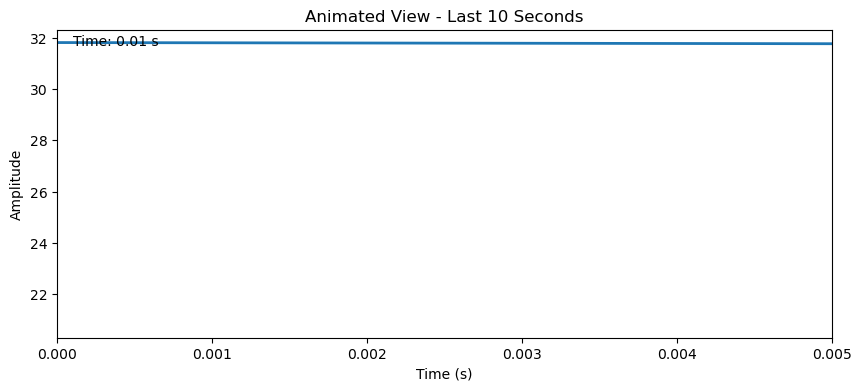

In [ ]:
from matplotlib.animation import FuncAnimation

def play_array(x, fs=200, duration=10):
    """
    Animate array x as a scrolling time plot at real-time speed.
    Shows a window of the last `duration` seconds.
    """
    x = np.asarray(x)
    n_samples = len(x)
    window_size = int(fs * duration)
    times = np.arange(n_samples) / fs

    fig, ax = plt.subplots(figsize=(10, 4))
    line, = ax.plot([], [], lw=2)
    ax.set_xlim(0, duration)
    ax.set_ylim(np.min(x), np.max(x))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

    def update(i):
        start = max(0, i - window_size)
        line.set_data(times[start:i], x[start:i])
        ax.set_xlim(times[start], times[start] + duration)
        return line,

    interval_ms = 1000 / fs  # real-time speed
    ani = FuncAnimation(fig, update, frames=range(1, n_samples), interval=interval_ms, blit=True)
    plt.show()




plot_rolling_animation(pupil_size[:1000])

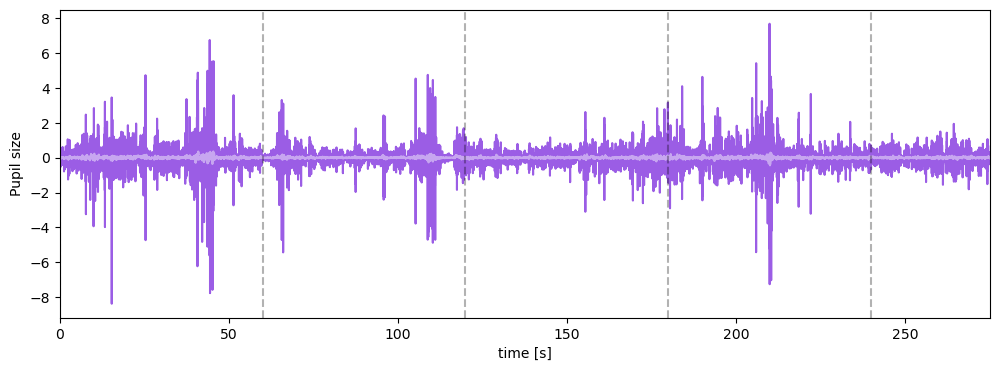

In [101]:
import scipy.signal as signal

def smooth_prime(x, win=10):
    x_prime = np.diff(x)
    for t in range(win, len(x)-win):
        minx = min(x[t-win:t+win])
        maxx = max(x[t-win:t+win])
        x_prime[t] = maxx-minx
    return x_prime

pupil_size_prime = np.diff(pupil_size)
pupil_size_prime_clean = np.diff(pupil_size_clean)
#pupil_size_prime_clean = smooth_prime(pupil_size_clean)

plt.figure(figsize=(12,4))
plt.plot(tv[1:], pupil_size_prime, color="#9b5de5")
plt.plot(tv[1:], pupil_size_prime_clean, color="#D3B9F4", alpha = 0.8)
plt.xlim([tv[0],tv[-1]])
plt.xlabel("time [s]")
plt.ylabel("Pupil size")

axes = plt.gca()
ylim = axes.get_ylim()
minutes = np.arange(0,tv[-1],60)
plt.vlines(minutes, ylim[0], ylim[1], colors="k",linestyles="--",alpha=0.3)
plt.ylim(ylim)
plt.show()

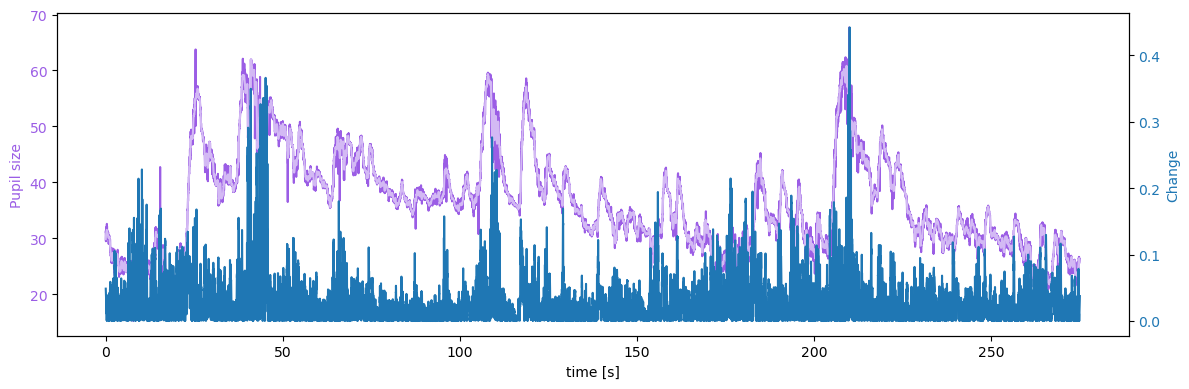

In [103]:
fig, ax1 = plt.subplots(figsize=(12,4))
color = "#9b5de5"
ax1.set_xlabel("time [s]")
ax1.set_ylabel("Pupil size", color=color)
ax1.plot(tv, pupil_size, color=color)
ax1.plot(tv, pupil_size_clean, color="#D3B9F4")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel("Change", color=color) 
ax2.plot(tv[1:], np.abs(pupil_size_prime_clean), color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

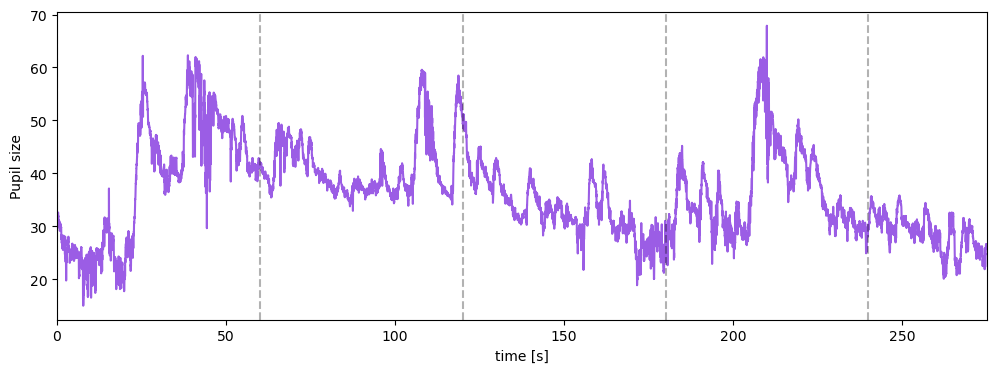

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(tv, pupil_size_prime, color="#9b5de5")
plt.xlim([tv[0],tv[-1]])
plt.xlabel("time [s]")
plt.ylabel("Pupil size")

axes = plt.gca()
ylim = axes.get_ylim()
minutes = np.arange(0,tv[-1],60)
plt.vlines(minutes, ylim[0], ylim[1], colors="k",linestyles="--",alpha=0.3)
plt.ylim(ylim)
plt.show()

In [76]:
import imageio
from matplotlib import cm
from io import BytesIO

def plot_trail_gif(data, filename='output.gif', trail_length=10, fps=30, dot_size=20, step=1):
    """
    Fast version: creates a GIF of a point moving with a fading trail using frame reuse.

    Parameters:
    - data: np.ndarray of shape (2, t)
    - filename: Output GIF filename
    - trail_length: Number of trail points to show
    - fps: GIF frames per second
    - dot_size: Size of points
    - step: Use every `step`-th frame (for downsampling)
    """
    x_data, y_data = data
    t = data.shape[1]
    lims = [100,150]
    fig, ax = plt.subplots()
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
    ax.axis('off')

    # Prepare plot elements
    trail_dots = [ax.plot([], [], 'o', color='blue', alpha=(trail_length - j) / trail_length, markersize=dot_size/5)[0]
                  for j in range(trail_length)]

    frames = []

    # Inside plot_trail_gif()

    # Add red dot for the current position (on top of blue trail)
    current_dot, = ax.plot([], [], 'o', color='red', markersize=dot_size / 4)

    # ... inside the frame loop ...
    for i in range(0, t, step):
        for j, dot in enumerate(trail_dots):
            idx = i - j
            if idx >= 0:
                dot.set_data([x_data[idx]], [y_data[idx]])
            else:
                dot.set_data([], [])

        # Set current (red) point
        if i < t:
            current_dot.set_data([x_data[i]], [y_data[i]])
        else:
            current_dot.set_data([], [])

        # Render frame
        fig.canvas.draw()
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frames.append(imageio.v2.imread(buf))
        buf.close()

    plt.close(fig)
    imageio.mimsave(filename, frames, fps=fps)
    print(f"GIF saved to {filename} with {len(frames)} frames.")

n_seconds = 50
plot_trail_gif(retina_center[:,:n_seconds*fps], filename='retina.gif', trail_length=30, fps=30,step=20)

GIF saved to retina.gif with 500 frames.
